In [3]:
import warnings
warnings.filterwarnings('ignore')

from glob import glob
import pandas as pd
import numpy as np 
from tqdm import tqdm
import cv2

import os
import timm
import random

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.metrics import f1_score, accuracy_score
import time


device = torch.device('cuda')

In [4]:
train_png = sorted(glob('data/train/*.png'))    # img_load 의 path
test_png = sorted(glob('data/test/*.png'))

In [5]:
train_y = pd.read_csv("data/train_df.csv")

train_labels = train_y["label"]

label_unique = sorted(np.unique(train_labels))
label_unique = {key:value for key,value in zip(label_unique, range(len(label_unique)))}

train_labels = [label_unique[k] for k in train_labels]

In [6]:
def img_load(path):
    img = cv2.imread(path)[:,:,::-1]   ## img[:,:,::-1] => BGR을 RGB로
    img = cv2.resize(img, (512, 512))
    return img

In [5]:
train_imgs = [img_load(m) for m in tqdm(train_png)]
test_imgs = [img_load(n) for n in tqdm(test_png)]

100%|███████████████████████████████████████| 2154/2154 [00:58<00:00, 36.55it/s]


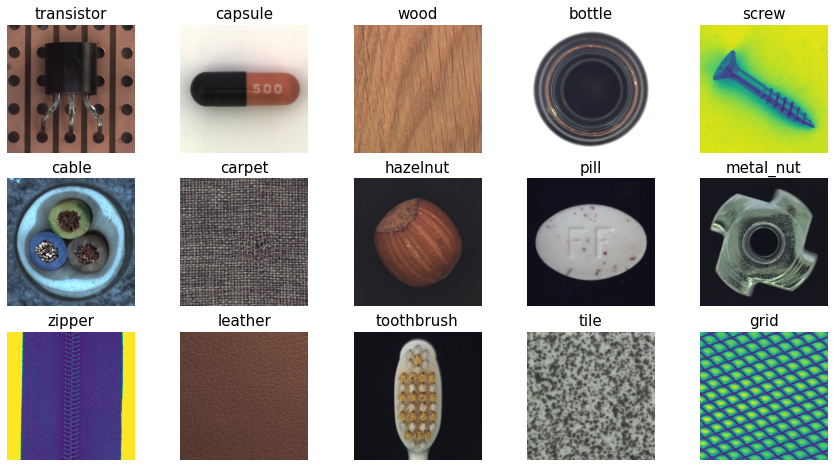

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as img
fig, axs = plt.subplots(3, 5, figsize=(15, 8))

folder_dir = 'data/train'

for i, current_class in enumerate(train_y['class'].unique()):
  image = img.imread(folder_dir+"/"+ train_y.loc[train_y['class'] == current_class]['file_name'].sample(1).iloc[0])
  axs[i//5, i%5].imshow(image)
  axs[i//5, i%5].set_title(current_class, fontsize=15)
  axs[i//5, i%5].axis('off')
plt.show()

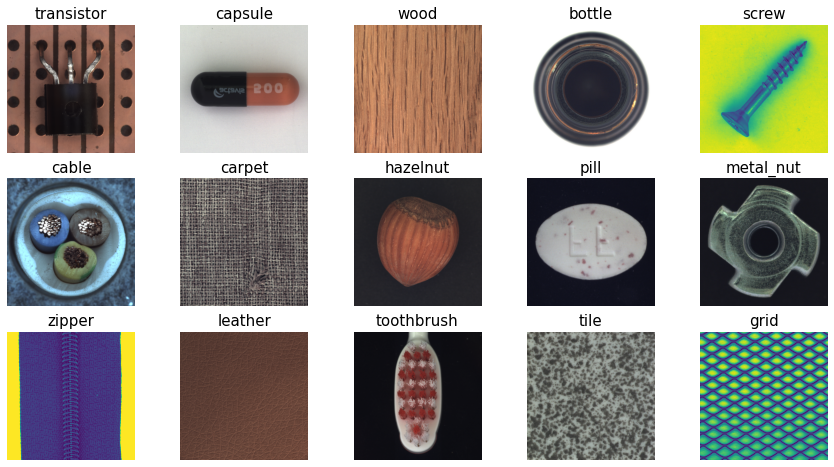

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as img
fig, axs = plt.subplots(3, 5, figsize=(15, 8))

folder_dir = 'data/train'

for i, current_class in enumerate(train_y['class'].unique()):
  image = img.imread(folder_dir+"/"+ train_y.loc[train_y['class'] == current_class]['file_name'].sample(1).iloc[0])
  image = image[::-1]
  axs[i//5, i%5].imshow(image)
  axs[i//5, i%5].set_title(current_class, fontsize=15)
  axs[i//5, i%5].axis('off')
plt.show()

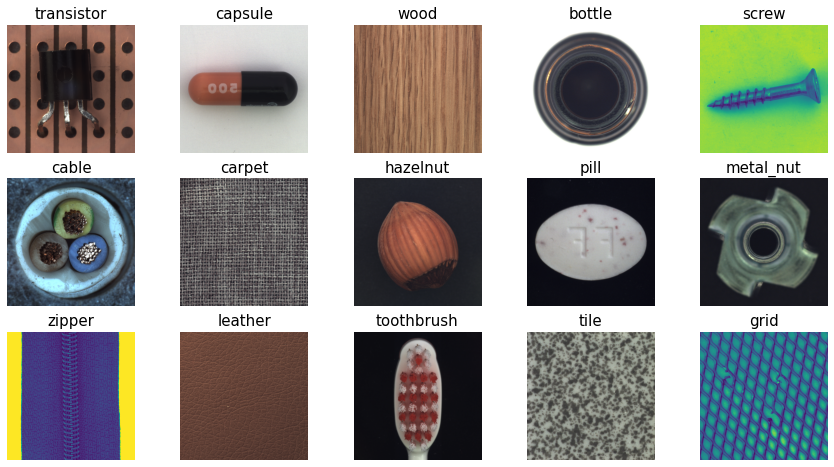

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as img
fig, axs = plt.subplots(3, 5, figsize=(15, 8))

folder_dir = 'data/train'

for i, current_class in enumerate(train_y['class'].unique()):
  image = img.imread(folder_dir+"/"+ train_y.loc[train_y['class'] == current_class]['file_name'].sample(1).iloc[0])
  image = image[:,::-1]
  axs[i//5, i%5].imshow(image)
  axs[i//5, i%5].set_title(current_class, fontsize=15)
  axs[i//5, i%5].axis('off')
plt.show()

In [6]:
class Custom_dataset(Dataset):
    def __init__(self, img_paths, labels, mode='train'):
        self.img_paths = img_paths
        self.labels = labels
        self.mode=mode
    def __len__(self):
        return len(self.img_paths)
    def __getitem__(self, idx):
        img = self.img_paths[idx]
        if self.mode=='train':
            augmentation = random.randint(0,2)    
            # augmentation이 성능향상에 중요
            # 1. 직접 augmentation 2. transforms 모듈 이용
            
            if augmentation==1:                ## 상하 반전
                img = img[::-1].copy()
            elif augmentation==2:              ## 좌우 반전
                img = img[:,::-1].copy()
        img = transforms.ToTensor()(img)     # network에 입력해줄 때 tensor로 변환
        if self.mode=='test':
            pass
        
        label = self.labels[idx]
        return img, label

# mytransform = transforms.Compose([
#     transforms.Resize((256, 256)),
#     transforms.RandomCrop(244),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
#     transforms.RandomRotation(degrees=(0, 360)),
#     transforms.RandomPerspective(),
#     transforms.ToTensor(),
# ])

# myvaltransform =transforms.Compose([
#     transforms.Resize((256, 256)),
#     transforms.ToTensor(),
# ])
    
    
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=88)
        # 모델 = efficientnet-b0
    def forward(self, x):
        x = self.model(x)
        return x

In [7]:
batch_size = 32
epochs = 25

# Train
train_dataset = Custom_dataset(np.array(train_imgs), np.array(train_labels), mode='train')
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

# Test
test_dataset = Custom_dataset(np.array(test_imgs), np.array(["tmp"]*len(test_imgs)), mode='test')
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

## 모델 학습

In [8]:
def score_function(real, pred):
    score = f1_score(real, pred, average="macro")
    return score

model = Network().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler() 



best=0
for epoch in range(epochs):
    start=time.time()
    train_loss = 0
    train_pred=[]
    train_y=[]
    model.train()
    for batch in (train_loader):
        optimizer.zero_grad()
        x = torch.tensor(batch[0], dtype=torch.float32, device=device)
        y = torch.tensor(batch[1], dtype=torch.long, device=device)
        with torch.cuda.amp.autocast():
            pred = model(x)
        loss = criterion(pred, y)


        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item()/len(train_loader)
        train_pred += pred.argmax(1).detach().cpu().numpy().tolist()
        train_y += y.detach().cpu().numpy().tolist()
        
    
    train_f1 = score_function(train_y, train_pred)

    TIME = time.time() - start
    print(f'epoch : {epoch+1}/{epochs}    time : {TIME:.0f}s/{TIME*(epochs-epoch-1):.0f}s')
    print(f'TRAIN    loss : {train_loss:.5f}    f1 : {train_f1:.5f}')

epoch : 1/25    time : 66s/1581s
TRAIN    loss : 1.02209    f1 : 0.22813
epoch : 2/25    time : 65s/1488s
TRAIN    loss : 0.52725    f1 : 0.40086
epoch : 3/25    time : 66s/1441s
TRAIN    loss : 0.39008    f1 : 0.52161
epoch : 4/25    time : 66s/1386s
TRAIN    loss : 0.28458    f1 : 0.60913
epoch : 5/25    time : 66s/1330s
TRAIN    loss : 0.25396    f1 : 0.67095
epoch : 6/25    time : 67s/1269s
TRAIN    loss : 0.20218    f1 : 0.74558
epoch : 7/25    time : 67s/1205s
TRAIN    loss : 0.17109    f1 : 0.75811
epoch : 8/25    time : 67s/1144s
TRAIN    loss : 0.16813    f1 : 0.80604
epoch : 9/25    time : 67s/1079s
TRAIN    loss : 0.15603    f1 : 0.79600
epoch : 10/25    time : 67s/1009s
TRAIN    loss : 0.13518    f1 : 0.82152
epoch : 11/25    time : 67s/940s
TRAIN    loss : 0.08898    f1 : 0.88312
epoch : 12/25    time : 67s/871s
TRAIN    loss : 0.07843    f1 : 0.91411
epoch : 13/25    time : 68s/818s
TRAIN    loss : 0.09165    f1 : 0.88324
epoch : 14/25    time : 69s/754s
TRAIN    loss : 0

## 추론

In [9]:
model.eval()
f_pred = []

with torch.no_grad():
    for batch in (test_loader):
        x = torch.tensor(batch[0], dtype = torch.float32, device = device)
        with torch.cuda.amp.autocast():
            pred = model(x)
        f_pred.extend(pred.argmax(1).detach().cpu().numpy().tolist())

In [10]:
label_decoder = {val:key for key, val in label_unique.items()}

f_result = [label_decoder[result] for result in f_pred]

## 제출물 생성

In [11]:
submission = pd.read_csv("data/sample_submission.csv")

submission["label"] = f_result

submission

,index,label
0,0,tile-glue_strip
1,1,grid-good
2,2,transistor-good
3,3,tile-gray_stroke
4,4,tile-good
...,...,...
2149,2149,tile-gray_stroke
2150,2150,screw-good
2151,2151,grid-good
2152,2152,cable-good


In [12]:
submission.to_csv("baseline_test.csv", index = False)